# Data Modeling

In [1]:
import pandas as pd

df = pd.read_csv("./data/df_cleaned.csv")

In this section I aim to make the model to classify the news items that were scraped from page 12.

In [2]:
#importamos librerías que utilizaremos en el trabajo
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [3]:
#importamos NLTK
try:
    import nltk
    print("Package: 'nltk' is already installed and loaded successfully")
except ModuleNotFoundError:
    print("Package: 'nltk' is not installed, will be installed")
    !pip install nltk
    import nltk


Package: 'nltk' is already installed and loaded successfully


In [4]:
import re
def limpiar_tokenizar(texto):

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('spanish'))
print(stop_words[:20])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I split the observations into a training set and a test set. This allows us to evaluate the capacity of the model. For this problem, a random 25% of the news items are selected as a test set.

In [6]:
import fast_ml

from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df[["all_text", "seccion"]], 
                                                                            target =  "seccion",
                                                                            train_size=0.7, 
                                                                            valid_size=0.15, 
                                                                            test_size=0.15)


print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(2190, 1)
(2190,)
(469, 1)
(469,)
(470, 1)
(470,)


(None, None)

## Vectorisation tf-idf

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that measures how important a word is to a document in a collection or corpus of documents.

The basic idea behind TF-IDF is to penalize words that occur frequently in a document and across many documents in the corpus, as these words are less informative and distinctive compared to words that occur less frequently.

The term frequency (TF) is the number of times a term appears in a document. The inverse document frequency (IDF) is the logarithmic scale of the number of documents in the corpus divided by the number of documents where the term appears. The product of these two values gives the TF-IDF weight of a term.

TF-IDF is widely used for text classification, information retrieval, and word representation learning. It is a simple yet powerful way to extract meaningful information from text data and is especially useful for analyzing and comparing large amounts of text data.

A tf-idf matrix is created.

In [16]:

tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizador.fit(X_train["all_text"].to_list())

TfidfVectorizer(min_df=3,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                tokenizer=<function limpiar_tokenizar at 0x0000017EE3E3B560>)

In [17]:
tfidf_train = tfidf_vectorizador.transform(X_train["all_text"].to_list())
tfidf_test  = tfidf_vectorizador.transform(X_test["all_text"].to_list())
tfidf_val  = tfidf_vectorizador.transform(X_valid["all_text"].to_list())

In [18]:
print(f" Number of tokens created: {len(tfidf_vectorizador.get_feature_names_out())}")
print(tfidf_vectorizador.get_feature_names_out()[:10])

 Number of tokens created: 8030
['aabe' 'abajo' 'abal' 'abandono' 'abarca' 'abastecimiento' 'abdomen'
 'abel' 'abierta' 'abiertas']


### Stemming

Stemming is a text processing technique in natural language processing that involves reducing words to their base or root form. The goal of stemming is to reduce the dimensionality of the text data by transforming words with similar meaning into a common form, thereby reducing the number of unique words in the text. 
This can be useful in order to improve the models that weren't as that good.

In [19]:
stemmer = nltk.stem.SnowballStemmer('spanish')

This function limpiar_tokenizar_stem takes a string of text as input and performs the following steps on it:

    1. Converts all the text to lowercase
    2. Removes web pages (words starting with "http") using a regular expression (re.sub)
    3. Removes punctuation using a regular expression (re.sub)
    4. Removes numbers using a regular expression (re.sub)
    5. Removes multiple spaces using a regular expression (re.sub)
    6. Tokenizes the text into individual words using the split method
    7. Removes tokens with a length less than 2
    8. Applies stemming to the tokens using the stemmer method (it seems that stemmer is an object that has already been defined)

The function returns a list of stemmed tokens (i.e., the root form of the words). The purpose of this function is to clean and preprocess the text data by converting it into a form that can be used for further analysis or processing.

In [20]:
def limpiar_tokenizar_stem(texto):

    nuevo_texto = texto.lower()
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    nuevo_texto = nuevo_texto.split(sep = ' ')
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    nuevo_texto = [stemmer.stem(token) for token in nuevo_texto]
    
    return(nuevo_texto)

In [21]:
tfidf_vectorizador_stem = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar_stem,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizador_stem.fit(X_train["all_text"].to_list())

TfidfVectorizer(min_df=3,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                tokenizer=<function limpiar_tokenizar_stem at 0x0000017EE4483CE0>)

In [22]:
train_tfidf_stem = tfidf_vectorizador.transform(X_train["all_text"].to_list())
test_tfidf_stem  = tfidf_vectorizador.transform(X_test["all_text"].to_list())
valid_tfidf_stem  = tfidf_vectorizador.transform(X_valid["all_text"].to_list())

## Linear SVM

Linear Support Vector Machines (SVMs) are a type of supervised machine learning algorithm used for binary classification and regression analysis. They are a variation of the standard SVM algorithm, where the decision boundary between classes is a linear boundary rather than a non-linear boundary.

In a linear SVM, the goal is to find the hyperplane in a high-dimensional feature space that best separates the data into two classes. This hyperplane is chosen such that it has the maximum margin, which is the distance between the hyperplane and the closest data points from either class, called support vectors.

Linear SVMs can be used for datasets with linearly separable classes, where the decision boundary between classes is a straight line. The linear SVM model tries to find the optimal hyperplane that maximizes the margin between the classes, while still correctly classifying all training samples.

I test using the GridSearch and Cross Validation technique for the fine tuning of the model.

In [23]:
param_grid = {'C': np.logspace(-3, 3, 20)}

grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 1,
        return_train_score = True
      )

fit = grid.fit(X = valid_tfidf_stem, y = y_valid)


resultados = pd.DataFrame(grid.cv_results_)

(
resultados.filter(regex = '(param.*|mean_t|std_t)')
          .drop(columns = 'params')
          .sort_values('mean_test_score', ascending = False)
          .head()
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
10,1.43845,0.87845,0.013965,1.0,0.0
11,2.976351,0.87845,0.013965,1.0,0.0
18,483.293024,0.87845,0.013965,1.0,0.0
17,233.572147,0.87845,0.013965,1.0,0.0
16,112.883789,0.87845,0.013965,1.0,0.0


In [24]:
print(f"Best hyperparameters found (cv) {grid.best_params_} - {grid.best_score_:.2f} {grid.scoring}")
modelo_final_svm = grid.best_estimator_

Best hyperparameters found (cv) {'C': 1.438449888287663} - 0.88 accuracy


In [47]:
modelo_final_svm.fit(train_tfidf_stem, y_train)

SVC(C=1.438449888287663, kernel='linear')

In [48]:
y_pred_test_SVM = modelo_final_svm.predict(test_tfidf_stem)

#### Metrics & Confussion Matrix

I  see the results in Test.

In [49]:
classes=y_train.unique()

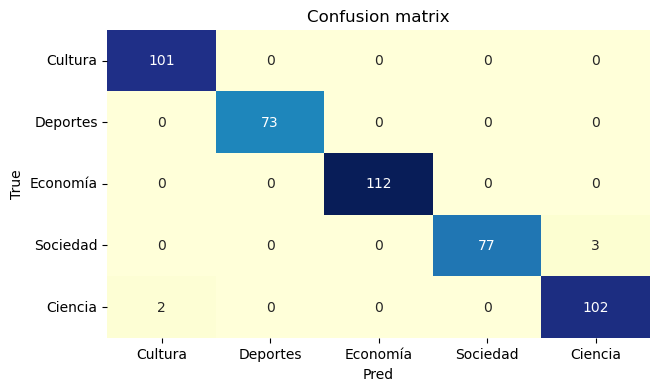

In [50]:
cm1 = metrics.confusion_matrix(y_true = y_test, y_pred = y_pred_test_SVM)
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(cm1, annot=True, fmt='d', ax=ax, cmap="YlGnBu", 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()


In [51]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred_test_SVM)
print("Accuracy:",  round(accuracy,4))
print("Details: ")
print(classification_report(y_test, y_pred_test_SVM, target_names=classes))

Accuracy: 0.9894
Details: 
              precision    recall  f1-score   support

     Cultura       0.98      1.00      0.99       101
    Deportes       1.00      1.00      1.00        73
    Economía       1.00      1.00      1.00       112
    Sociedad       1.00      0.96      0.98        80
     Ciencia       0.97      0.98      0.98       104

    accuracy                           0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470



## Random Forest 

Now I will try with a tree-based model, Random Forest. Random Forest is an ensemble learning method for classification and regression problems in machine learning. It is based on decision trees, which are constructed by recursively splitting the data into smaller and smaller subsets based on the values of the input features.

A Random Forest consists of multiple decision trees, each of which is trained on a randomly selected subset of the training data. The outputs of the individual trees are combined to form the final prediction, either by taking the average in regression problems or by taking a majority vote in classification problems.

I find the best parameters for the model with the validation dataset.

In [32]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [5,30,50,100, 150]
max_depth = [2,5,8,10,15,20]
min_samples_split = [2,3]

param_grid = {"n_estimators" : n_estimators,
              "max_depth" : max_depth,
              "min_samples_split" : min_samples_split}

grid_rf = GridSearchCV(
        estimator  = RandomForestClassifier(),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 1,
        return_train_score = True
      )

fit = grid_rf.fit(X = valid_tfidf_stem, y = y_valid)


resultados_rf = pd.DataFrame(grid_rf.cv_results_)

(
resultados_rf.filter(regex = '(param.*|mean_t|std_t)')
          .drop(columns = 'params')
          .sort_values('mean_test_score', ascending = False)
          .head()

)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
53,20,2,100,0.816512,0.061584,0.982944,0.003980
54,20,2,150,0.814484,0.029230,0.987210,0.002596
59,20,3,150,0.812320,0.044687,0.984012,0.004509
58,20,3,100,0.805937,0.035790,0.977608,0.002642
52,20,2,50,0.797458,0.047415,0.974400,0.009094


Now I look for the best hyperparameters: 

In [33]:
print(f"Best hyperparameters found (cv) {grid_rf.best_params_} - {grid_rf.best_score_:.2f} {grid_rf.scoring}")
modelo_final_rf = grid_rf.best_estimator_

Best hyperparameters found (cv) {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100} - 0.82 accuracy


I train the best model with train data.

In [41]:
modelo_final_rf.fit(train_tfidf_stem, y_train)

RandomForestClassifier(max_depth=20)

And I predict with test data in order to validate:

In [42]:
y_pred_test_rf = modelo_final_rf.predict(test_tfidf_stem)

#### Metrics & Confussion Matrix

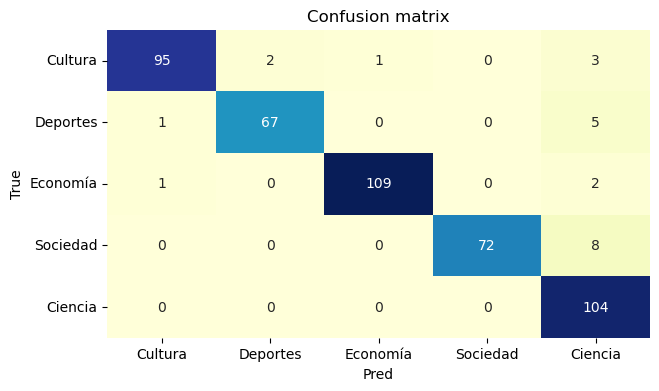

In [43]:
cm1 = metrics.confusion_matrix(y_true = y_test, y_pred = y_pred_test_rf)
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(cm1, annot=True, fmt='d', ax=ax, cmap="YlGnBu", 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()


In [44]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred_test_rf)
print("Accuracy:",  round(accuracy,4))
print("Details: ")
print(classification_report(y_test, y_pred_test_rf, target_names=classes))

Accuracy: 0.9511
Details: 
              precision    recall  f1-score   support

     Cultura       0.98      0.94      0.96       101
    Deportes       0.97      0.92      0.94        73
    Economía       0.99      0.97      0.98       112
    Sociedad       1.00      0.90      0.95        80
     Ciencia       0.85      1.00      0.92       104

    accuracy                           0.95       470
   macro avg       0.96      0.95      0.95       470
weighted avg       0.96      0.95      0.95       470



## Naive Bayes Multinomial Model

Naive Bayes Multinomial is a probabilistic algorithm that makes use of the Bayes theorem to classify text data. The algorithm is based on the assumption of "Naive" Bayes, which means that all features of the data are assumed to be conditionally independent, given the class label.

In the multinomial variant of Naive Bayes, the features are counted occurrences of words or terms in a document, and the class labels represent categories or topics. The algorithm uses the word counts to estimate the probabilities of each class given the document, and then uses Bayes' theorem to compute the probability of each class for a new document, and predicts the class label with the highest probability.

In [52]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

nv_multinomial = naive_bayes.MultinomialNB()

nv_multinomial.fit(train_tfidf_stem, y_train)

MultinomialNB()

In [54]:
## test
y_pred_multinomial = nv_multinomial.predict(test_tfidf_stem)
y_proba_pred_multinomial = nv_multinomial.predict_proba(test_tfidf_stem)

In [55]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values

In [56]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred_multinomial)
auc = metrics.roc_auc_score(y_test, y_proba_pred_multinomial, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred_multinomial))

Accuracy: 0.97
Auc: 1.0
Detail:
              precision    recall  f1-score   support

     Ciencia       0.95      1.00      0.98       101
     Cultura       1.00      0.97      0.99        73
    Deportes       1.00      0.98      0.99       112
    Economía       0.96      0.96      0.96        80
    Sociedad       0.95      0.94      0.95       104

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



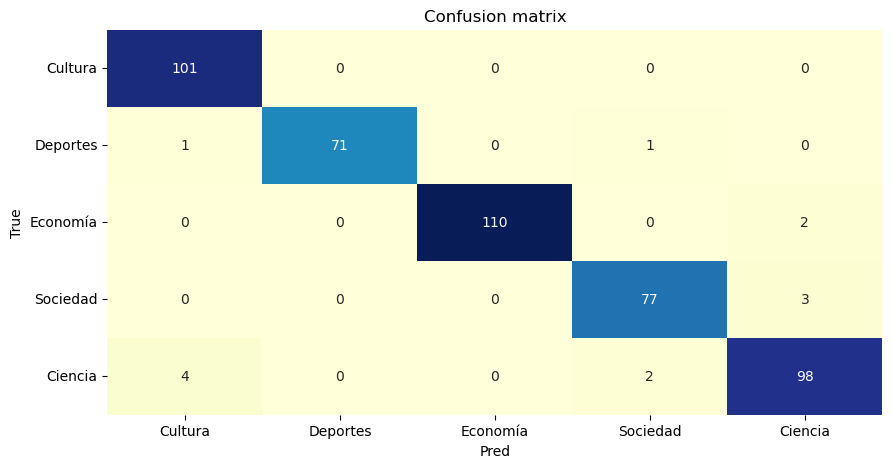

In [59]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_multinomial)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="YlGnBu", 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()